In [1]:

## refref process images in real time (simple bee in / out at each timestep)

import nectarUtils
from nectarUtils import *
import nectarUtils as nu

import importlib


%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

3.5.4 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:15:17) [MSC v.1900 64 bit (AMD64)]
C:\Users\Combes4\Anaconda2\envs\NectarCamera\python.exe


In [3]:
# list serial ports
nu.serial_ports()

['COM4', 'COM8']

In [4]:
# connect to com8
PORT1 = "COM4"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))    

connected to arduino on COM4


' Setup complete\r\n'

In [5]:
# connect to com8
PORT2 = "COM8"
connected2 = False
if "ser2" in globals():
    ser2.close()
ser2 = serial.Serial(PORT2,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected2:
    serin2 = ser2.read()
    connected2 = True
    print("connected to arduino on " + PORT2)
str(ser2.readline().decode("UTF-8"))    

connected to arduino on COM8


' Setup complete\r\n'

In [329]:
ser2.write("ff".encode("utf-8"))

2

In [489]:
ser1.write("ff".encode("utf-8"))

2

In [205]:
def moveBack(ser):
    ser.write("ff".encode("utf-8"))
    #raise("ERROR")
    return("Hihi" + ser.port)

In [206]:
moveBack(ser1)

'HihiCOM4'

In [1390]:
ser2.write("ff".encode("utf-8"))
ser1.write("ff".encode("utf-8"))

2

In [1444]:
ser1.port

'COM4'

In [1622]:
ser1.write("ff".encode("utf-8"))

2

In [1623]:
# calibrate both at the same time

_ = importlib.reload(nectarUtils)



In [1624]:
# cal1, cal2 = nu.multiCalibrate(ser1, ser2)
cal1 = nu.multiCalibrate(ser1)

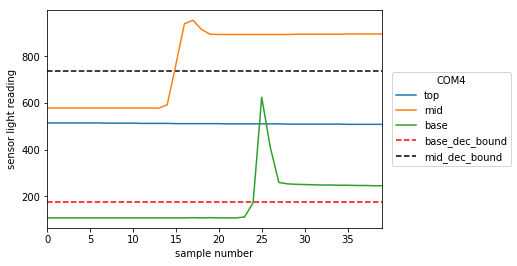

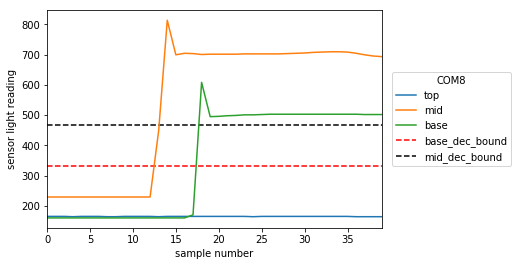

In [1625]:
_ = importlib.reload(nectarUtils)
nu.plotCalibration(cal1)
nu.plotCalibration(cal2)
    


In [1627]:
dataDir

'D:\\Dropbox\\AcademiaDropbox\\UW\\BeeDecisionProject\\NectarData'

# Simultaneous data collection


In [1641]:
import subprocess
from subprocess import Popen, PIPE, STDOUT
proc = subprocess.Popen('bash cameraSetup.sh &', shell = False)
    
# Call a bash script -- note that the & makes it run in the background
#proc = subprocess.Popen('bash cameraRecord.sh C:\\Users\\Combes4\\Desktop\\TempVids &')
# proc = subprocess.Popen('bash cameraRecord.sh C:\\Users\\Combes4\\Desktop\\TempVids &', shell = False)

In [1642]:
subprocess.Popen("TASKKILL /F /PID {pid} /T".format(pid=proc.pid)) # but then the avi won't play

In [1645]:
_ = importlib.reload(nectarUtils)
proc = subprocess.Popen('bash cameraRecord.sh C:\\Users\\Combes4\\Desktop\\TempVids &', shell = False)
dat1, dat1_file, dat2, dat2_file = nu.multiReadAndSave(ser1, ser2, cal1, cal2,
                                                       dataDir = dataDir, maxTime = 15)
print("DONE")
#subprocess.Popen("TASKKILL /F /PID {pid} /T".format(pid=proc.pid))

4.0 seconds elapsed
6.0 seconds elapsed
DONE


In [1637]:
dat2.head()

,mid,top,base,limit_1,limit_2,timestamp,port,notes
0,710,162,225,0,0,2019-03-21 15:33:47.718853,COM8,"{'base_dec_bound': 332, 'baseBaseline': 161.0,..."
1,710,162,179,0,0,2019-03-21 15:33:47.767598,COM8,NaN
2,710,162,194,0,0,2019-03-21 15:33:47.812730,COM8,NaN
3,710,162,181,0,0,2019-03-21 15:33:47.850112,COM8,NaN
4,710,162,184,0,0,2019-03-21 15:33:47.907096,COM8,NaN


In [1639]:
# combine datasets
dat_combined = dat1.append(pd.DataFrame( dat2), ignore_index=True)
dat_combined.tail()

,base,limit_1,limit_2,mid,notes,port,timestamp,top
420,161,0,0,710,NaN,COM8,2019-03-21 15:33:58.240597,162
421,161,0,0,710,NaN,COM8,2019-03-21 15:33:58.290541,162
422,161,0,0,710,NaN,COM8,2019-03-21 15:33:58.340523,162
423,161,0,0,710,NaN,COM8,2019-03-21 15:33:58.390589,162
424,161,0,0,710,NaN,COM8,2019-03-21 15:33:58.440586,162


In [1640]:
# save combined dataset
dat_combined.to_csv(os.path.join(dataDir, np.sort([dat2_file, dat1_file])[0].replace(".", "___cmbnd.")), index = False)

In [1502]:
import subprocess

In [1519]:
# refref here: 
# I want to start a subprocess to collect video data
subprocess.check_call(r"for i in 1 2 3 4 5; do sleep 0.1s; done", shell=True)

0

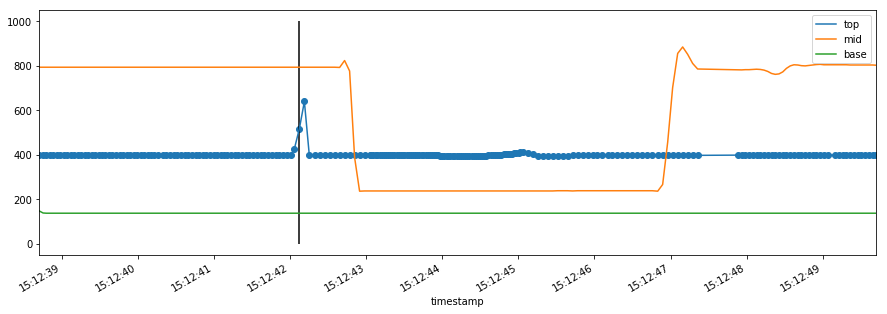

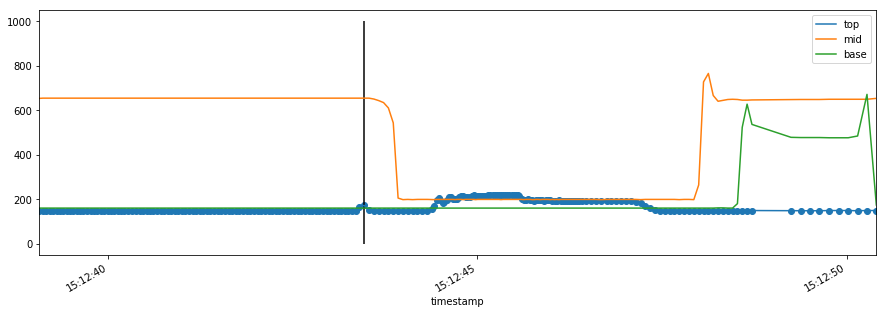

In [1479]:
nu.plotTrial(dat1)
nu.plotTrial(dat2)

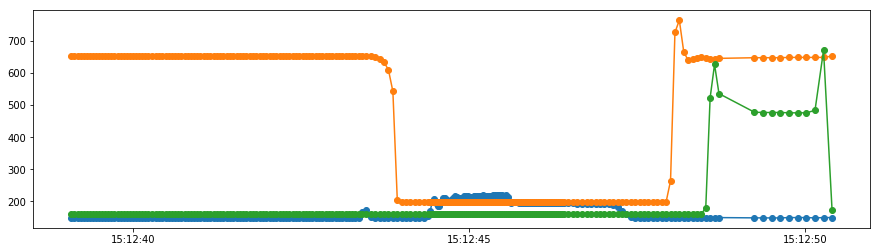

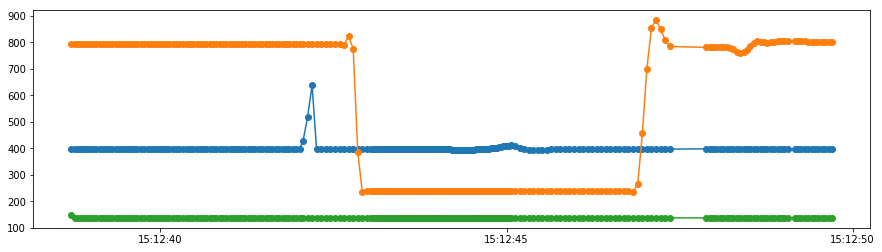

In [1481]:
plt.figure(figsize = [15,4])
plt.plot(dat_combined.loc[dat_combined.port == "COM8"]["timestamp"],
         dat_combined.loc[dat_combined.port == "COM8"][["top", "mid", "base"]], '-', marker = "o")

plt.show()
plt.figure(figsize = [15,4])
plt.plot(dat_combined.loc[dat_combined.port == "COM4"]["timestamp"],
         dat_combined.loc[dat_combined.port == "COM4"][["top", "mid", "base"]], '-', marker = "o")
plt.show()
#dat_combined.loc[dat_combined.port == "COM4"].plot(y = "base", x = "timestamp")

In [1331]:
_ = importlib.reload(nectarUtils)
t = threading.Thread(target = nu.readAndSave, kwargs={"serial_con" : ser2, "calibrationInfo" : cal2 , 
                                                     "dataDir" : dataDir})
t.start()

4.0 seconds elapsed
No action for 10 sec


In [1332]:
t

<Thread(Thread-86, stopped 13700)>

In [1304]:
_ = importlib.reload(nectarUtils)
nu.readAndSave(serial_con = ser2, calibrationInfo= cal2, dataDir = dataDir)

4.0 seconds elapsed
No action for 10 sec


,mid,top,base,limit_1,limit_2,timestamp,notes
0,619,147,161,0,0,2019-03-15 13:30:08.353088,"{'topBaseline': 144.55, 'midBaseline': 188.0, ..."
1,619,147,161,0,0,2019-03-15 13:30:08.513127,NaN
2,619,147,163,0,0,2019-03-15 13:30:08.562098,NaN
3,619,147,160,0,0,2019-03-15 13:30:08.614879,NaN
4,619,147,161,0,0,2019-03-15 13:30:08.664774,NaN
5,619,147,160,0,0,2019-03-15 13:30:08.713742,NaN
6,619,147,161,0,0,2019-03-15 13:30:08.762605,NaN
7,619,147,161,0,0,2019-03-15 13:30:08.811577,NaN
8,619,147,160,0,0,2019-03-15 13:30:08.861046,NaN
9,619,147,160,0,0,2019-03-15 13:30:08.910017,NaN


In [1313]:
#cal2['topBaseline', 'midBaseline', 'baseBaseline', 'colNames', 'port', 'base_dec_bound', 'mid_dec_bound']

KeyError: ('topBaseline', 'midBaseline', 'baseBaseline', 'colNames', 'port', 'base_dec_bound', 'mid_dec_bound')

{'topBaseline': 144.55,
 'midBaseline': 188.0,
 'baseBaseline': 160.0,
 'colNames': array(['mid', 'top', 'base', 'limit', 'limit'], dtype=object),
 'port': 'COM8',
 'base_dec_bound': 312,
 'mid_dec_bound': 382}